In [1]:
# This notebook contains code for executing the tasks described (and depicted) in
# Tutorial Step 4: Analysis

from bfbrain import BFBLearner, MC_call_fast, BALD
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

# Generate a 2-D cross section of the inert doublet model
# (IDM) parameter space.
rng = default_rng(12345)

slice_scan = np.empty(shape = (2000, 10))
slice_scan[:,0] = 10.
slice_scan[:,3] = 1.
slice_scan[:,4] = 5.
slice_scan[:,5:] = 0.
slice_scan[:,1] = rng.uniform(0., 10., len(slice_scan))
slice_scan[:,2] = rng.uniform(-5., 5., len(slice_scan))

# Load the neural network produced in tutorial_step_3.ipynb.
# (this classifier was produced already in the examples folder,
# so there's no need to go through that notebook if you haven't
# already)
AL = BFBLearner.from_file('saved_AL')

# Get quantitative information about the scales of model uncertainties
# by generating 10^5 points uniformly sampled from the surface of the 
# hypersphere, computing the model's mutual information on each point
# and preserving the results for all points that the model predicts
# to be bounded-from-below (which tend to have higher uncertainties).
cal_set = AL.get_calibration_uncertainties(score_fn = 'BALD', nlams = 100000, n_trials = 100)

# Make predictions on rand_lams using Monte Carlo dropout with 
# 100 forward passes through the network.
preds = (MC_call_fast(AL.model, slice_scan, n_trials = 100) >= 0.5).numpy()

uncerts = BALD(AL.model, slice_scan, n_trials = 100).numpy()

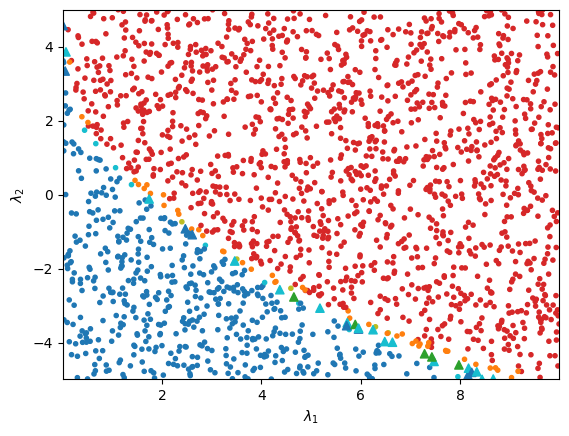

In [2]:
# Two plotting helper functions. 
# generate_colors colors plots based on their uncertainty
# (estimated via mutual information) and classification.
def generate_colors(preds, uncerts, calibration_set):

    quantile_95 = np.quantile(calibration_set, 0.95)
    quantile_99 = np.quantile(calibration_set, 0.99)

    def check_color(pred, uncert):
        if(pred >= 0.5):
            if uncert > quantile_99:
                return 'tab:olive'
            if uncert > quantile_95:
                return 'tab:orange'
            return 'tab:red'
        else:
            if uncert > quantile_99:
                return 'tab:green'
            if uncert > quantile_95:
                return 'tab:cyan'
            return 'tab:blue'
    return np.array([check_color(pred, uncerts[i]) for i, pred in enumerate(preds)])

# find_good_predictions uses the truth-level expression
# for the bounded-from-below conditions in the inert 
# doublet model to identify where the BFBrain model is
# wrong for this subset of 2HDM's.
def find_good_predictions(lams, preds):
    def truth_BFB(lam):
        if lam[0] <= 0 or lam[1] <= 0:
            return False
        if lam[2] + np.sqrt(lam[0]*lam[1]) <= 0:
            return False
        return lam[2] + lam[3] - np.abs(lam[4]) + np.sqrt(lam[0]*lam[1]) > 0
    def check_pred(pred, lam):
        return (pred and truth_BFB(lam)) or ((not pred) and not truth_BFB(lam))
    return np.array([check_pred(preds[ind], lams[ind]) for ind in range(len(lams))])

colors_in = generate_colors(preds, uncerts, cal_set)
good_preds = find_good_predictions(slice_scan, preds)

# Produce a scatter plot of the BFBrain model's predictions.
fig, ax = plt.subplots()
ax.scatter(np.transpose(slice_scan)[1][good_preds], np.transpose(slice_scan)[2][good_preds], c = colors_in[good_preds], marker = '.')
ax.scatter(np.transpose(slice_scan)[1][~good_preds], np.transpose(slice_scan)[2][~good_preds], c = colors_in[~good_preds], marker = '^')
ax.set_xlabel(r'$\lambda_1$')
ax.set_ylabel(r'$\lambda_2$')
ax.margins(x=0,y=0)
plt.show()
fig.savefig('slice_scan_example.png', format='png', bbox_inches='tight')

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model('saved_AL/model')

# Generate a random batch of quartic coupling coefficient sets.
test_input = tf.random.uniform(shape=(10000, 10), minval = -5., maxval = 5.)

# Calling the model normally will give a deterministic result, since Tensorflow assumes dropout
# is only used during training.
# Dropout can be included with the flag training = True. This gives a single prediction with dropout.
pred = model(test_input, training = True)

# We can write a function which does Monte Carlo dropout as follows:
def MC_call(model, lams, n_trials):
    result = tf.reshape(model(lams, training = True), shape=[-1])/tf.cast(tf.constant(n_trials), tf.float32)
    for _ in tf.range(tf.constant(1), tf.constant(n_trials)):
        result = result + tf.reshape(model(lams, training = True), shape=[-1])/ tf.cast(tf.constant(n_trials), tf.float32)
    return result